In [ ]:
#default_exp interpret.interpret

# Analyse Model Confidence

This module provides a replacement for fastai's [`ClassificationInterpretation`](https://dev.fast.ai/interpret) class in a few ways:
* Store predictions in a `pandas.DataFrame` object
* Prediction confidence plots
* Per label prediction accuracy plot
* More legible `plot_top_losses`

In [ ]:
#hide
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai.vision.all import *
from fastai.metrics import *
import PIL

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#hide
from cinemanet.train.data_handler import *
from cinemanet.train.helpers import *

warnings.simplefilter('ignore')
dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-framing.json",
                is_multilabel=False, verbose=False)
    .get_dataset_df('train-clean', 'valid-clean')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

helper = ClassificationHelper(dhandler, '__', save_path="/tmp", antialiased=True)
learn  = helper.get_learner()
_learn = load_learner("../framing-1.pkl")
learn.model.load_state_dict(_learn.model.state_dict())

<All keys matched successfully>

### Setup

For some context, the model I'm using here is a single-label classifier with a softmax activation, and has 9 classes:

`01-extremewide` <br>
`02-wide` <br>
`03-long` <br>
`04-medium-long` <br>
`05-medium` <br>
`06-medium-close-up` <br>
`07-closeup` <br>
`08-extreme-close-up` <br>
`09-zz-NA` <br>

In [ ]:
#export
from fastai_amalgam.utils import *
from fastai_amalgam.show_data import *

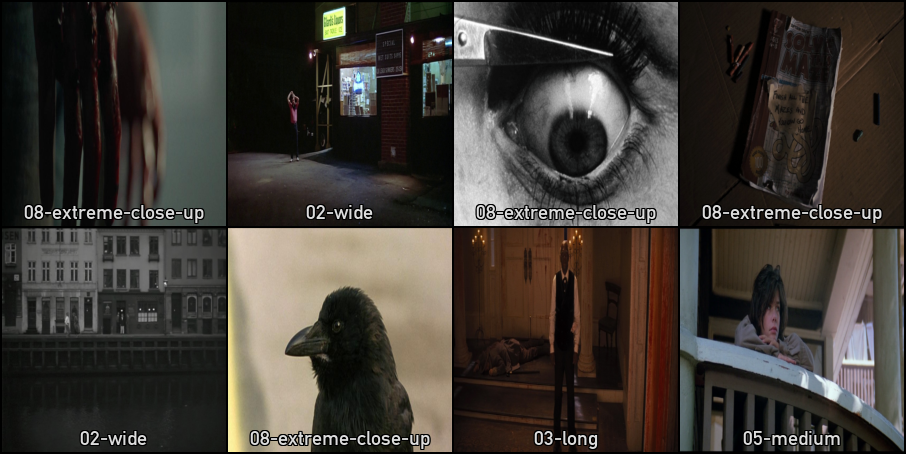

In [ ]:
learn.dls.set_font_path("../fonts/DIN Alternate Bold.ttf")
learn.dls.show_batch_grid(n=8)

## ClassificationInterpretationEx

In [ ]:
#export
import fastai
class ClassificationInterpretationEx(ClassificationInterpretation):
    """
    Extend fastai2's `ClassificationInterpretation` to analyse model predictions in more depth
    See:
      * self.preds_df
      * self.plot_label_confidence()
      * self.plot_confusion_matrix()
      * self.plot_accuracy()
      * self.get_fnames()
    """
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        super().__init__(dl, inputs, preds, targs, decoded, losses)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]
        self.compute_label_confidence()
    
    def compute_label_confidence(self):
        """
        Collate prediction confidence, filenames, and ground truth labels
        in DataFrames, and store them as class attributes
        `self.preds_df` and `self.preds_df_each`
        """
        if not isinstance(self.dl.items, pd.DataFrame):
            self._preds_collated = [
                (item, self.dl.vocab[label_idx], *preds.numpy()*100)\
                for item,label_idx,preds in zip(self.dl.items,
                                                self.targs,
                                                self.preds)
            ]
        ## need to extract fname from DataFrame
        elif isinstance(self.dl.items, pd.DataFrame):
            self._preds_collated = [
                (item.fnames, self.dl.vocab[label_idx], *preds.numpy()*100)\
                for (_,item),label_idx,preds in zip(self.dl.items.iterrows(),
                                                self.targs,
                                                self.preds)
            ]        

        self.preds_df       = pd.DataFrame(self._preds_collated, columns = ['fname','truth', *self.dl.vocab])
        self.preds_df.insert(2, column='loss', value=self.losses.numpy())
        self._preds_df_each = {l:self.preds_df.copy()[self.preds_df.truth == l].reset_index(drop=True) for l in self.dl.vocab}
        self.preds_df_each  = defaultdict(dict)


        sort_desc = lambda x,col: x.sort_values(col, ascending=False).reset_index(drop=True)
        for label,df in self._preds_df_each.items():
            filt = df[label] == df[self.dl.vocab].max(axis=1)
            self.preds_df_each[label]['accurate']   = df.copy()[filt]
            self.preds_df_each[label]['inaccurate'] = df.copy()[~filt]

            self.preds_df_each[label]['accurate']   = sort_desc(self.preds_df_each[label]['accurate'], label)
            self.preds_df_each[label]['inaccurate'] = sort_desc(self.preds_df_each[label]['inaccurate'], label)
            assert len(self.preds_df_each[label]['accurate']) + len(self.preds_df_each[label]['inaccurate']) == len(df)
        
    def get_fnames(self, label:str,
                   mode:('accurate','inaccurate'),
                   conf_level:Union[int,float,tuple]) -> np.ndarray:
        """
        Utility function to grab filenames of a particular label `label` that were classified
        as per `mode` (accurate|inaccurate).
        These filenames are filtered by `conf_level` which can be above or below a certain
        threshold (above if `mode` == 'accurate' else below), or in confidence ranges
        """
        assert label in self.dl.vocab
        if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
        df = self.preds_df_each[label][mode].copy()
        if mode == 'accurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] > conf_level
        if mode == 'inaccurate':
            if isinstance(conf_level, tuple):       filt = df[label].between(*conf_level)
            if isinstance(conf_level, (int,float)): filt = df[label] < conf_level
        return df[filt].fname.values

In [ ]:
interp = ClassificationInterpretationEx.from_learner(learn)

In [ ]:
show_doc(ClassificationInterpretationEx.compute_label_confidence)

<h4 id="ClassificationInterpretationEx.compute_label_confidence" class="doc_header"><code>ClassificationInterpretationEx.compute_label_confidence</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.compute_label_confidence</code>()

```
Collate prediction confidence, filenames, and ground truth labels
in DataFrames, and store them as class attributes
`self.preds_df` and `self.preds_df_each`
```

`self.preds_df` has (3 + num. labels) columns. <br>
1. `fname` has the path to the file on disk <br>
2. `truth` has the ground truth <br>
3. `loss` <br>
3. The third column onwards contain label confidence for each label (in %)

In [ ]:
interp.preds_df.head()

,fname,truth,loss,01-extremewide,02-wide,03-long,04-medium-long,05-medium,06-medium-close-up,07-closeup,08-extreme-close-up,09-zz-NA
0,2001__a_space_odyssey__1968__003_cropped.jpg,06-medium-close-up,0.794275,0.010279,0.028512,0.015695,0.029457,0.656558,45.190861,53.375996,0.674003,0.018635
1,2001__a_space_odyssey__1968__008_cropped.jpg,06-medium-close-up,5.130556,0.047301,0.087036,0.231384,0.066522,0.232201,0.591327,2.291630,96.282990,0.169614
2,2001__a_space_odyssey__1968__038_cropped.jpg,06-medium-close-up,1.681330,0.730931,10.786359,12.567484,8.616324,17.877941,18.612625,4.766017,22.473766,3.568554
3,2001__a_space_odyssey__1968__041_cropped.jpg,06-medium-close-up,0.128396,0.003820,0.022054,0.010768,0.006982,0.772622,87.950462,10.650743,0.577822,0.004725
4,2001__a_space_odyssey__1968__043_cropped.jpg,06-medium-close-up,2.857214,0.158497,0.432986,1.886084,3.124176,2.371618,5.742850,74.707771,11.379311,0.196710


`self.preds_df_each` is a two-level dictionary.

The keys at the first level are the names of the labels (`self.dl.vocab`) <br>
The second level has two keys -- `'accurate'` and `'inaccurate'`, both of which <br>
store `pd.DataFrame`s sorted in descending order of label confidence

This allows you to quickly find the location to the files based on confidence, and you can easily save these to disk for more detailed perusal and to gain insights on where your model fails

In [ ]:
assert interp.dl.vocab == interp.preds_df_each.keys()

In [ ]:
interp.preds_df_each['02-wide']['accurate'].head(3)

,fname,truth,loss,01-extremewide,02-wide,03-long,04-medium-long,05-medium,06-medium-close-up,07-closeup,08-extreme-close-up,09-zz-NA
0,aloha__2015__056_cropped.jpg,02-wide,0.000233,0.002799,99.976746,0.017383,0.002745,0.000015,0.000058,0.000025,0.000171,0.000060
1,a_clockwork_orange_34_exercise_yard.png,02-wide,0.000347,0.015065,99.965286,0.017150,0.001307,0.000016,0.000110,0.000084,0.000635,0.000361
2,across_the_universe_621.jpg,02-wide,0.000464,0.026326,99.953552,0.014546,0.003089,0.000095,0.000376,0.000213,0.001681,0.000112


---

### ClassificationInterpretationEx.get_fnames

In [ ]:
show_doc(ClassificationInterpretationEx.get_fnames)

<h4 id="ClassificationInterpretationEx.get_fnames" class="doc_header"><code>ClassificationInterpretationEx.get_fnames</code><a href="__main__.py#L57" class="source_link" style="float:right">[source]</a></h4>

> <code>ClassificationInterpretationEx.get_fnames</code>(**`label`**:`str`, **`mode`**:`('accurate', 'inaccurate')`, **`conf_level`**:`Union`\[`int`, `float`, `tuple`\])

```
Utility function to grab filenames of a particular label `label` that were classified
as per `mode` (accurate|inaccurate).
These filenames are filtered by `conf_level` which can be above or below a certain
threshold (above if `mode` == 'accurate' else below), or in confidence ranges
```

In [ ]:
# return accuratly classified files with accuracy above 85%
interp.get_fnames('02-wide', 'accurate', 99.95)

array(['aloha__2015__056_cropped.jpg',
       'a_clockwork_orange_34_exercise_yard.png',
       'across_the_universe_621.jpg'], dtype=object)

In [ ]:
# return inaccurately classified files with accuracy between 84.1 - 85.2%
interp.get_fnames('02-wide', 'accurate', (84.1, 85.2))

array(['5_dolls_august_mmoon_fivedolls002.jpg',
       'big_lebowski__the__1998__022_cropped.jpg'], dtype=object)

---

### Confusion Matrix

In [ ]:
#export
from palettable.scientific.sequential import Davos_3_r

@patch
def plot_confusion_matrix(self:ClassificationInterpretationEx, normalize=True, title='Confusion matrix', cmap=None, norm_dec=2,
                          plot_txt=True, return_fig=False, dpi=100, **kwargs):
    """
    Plot the confusion matrix

    A near exact replica of fastai's method, with the added option
    of `return_fig`, to be able to save the image to disk and a
    different default colormap
    """
    # This function is mainly copied from the sklearn docs
    cm = interp.confusion_matrix()
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(dpi=dpi, **kwargs)
    if cmap is None: cmap=Davos_3_r.mpl_colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(interp.vocab))
    plt.xticks(tick_marks, interp.vocab, rotation=90)
    plt.yticks(tick_marks, interp.vocab, rotation=0)

    if plot_txt:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(interp.vocab)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_confusion_matrix)

In [ ]:
interp.plot_confusion_matrix(cmap=Davos_3_r.mpl_colormap, figsize=(8,8))

---

In [ ]:
#export
@patch
def plot_accuracy(self:ClassificationInterpretationEx, width=0.9, figsize=(6,6), return_fig=False,
                  title='Accuracy Per Label', ylabel='Accuracy (%)', style='ggplot',
                  color='#2a467e', vertical_labels=True):
    'Plot a bar plot showing accuracy per label'
    plt.style.use(style)
    if not hasattr(self, 'preds_df_each'): self.compute_label_confidence()
    self.accuracy_dict = defaultdict()

    for label,df in self.preds_df_each.items():
        total = len(df['accurate']) + len(df['inaccurate'])
        self.accuracy_dict[label] = 100 * len(df['accurate']) / total

    fig,ax = plt.subplots(figsize=figsize)

    x = self.accuracy_dict.keys()
    y = [v for k,v in self.accuracy_dict.items()]

    rects = ax.bar(x,y,width,color=color)
    for rect in rects:
        ht = rect.get_height()
        ax.annotate(s  = f"{ht:.02f}",
                    xy = (rect.get_x() + rect.get_width()/2, ht),
                    xytext = (0,3), # offset vertically by 3 points
                    textcoords = 'offset points',
                    ha = 'center', va = 'bottom'
                   )
    ax.set_ybound(lower=0, upper=100)
    ax.set_yticks(np.arange(0,110,10))
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(x, rotation='vertical' if vertical_labels else 'horizontal')
    plt.suptitle(title)
    plt.tight_layout()
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_accuracy)

In [ ]:
interp.plot_accuracy()

---

In [ ]:
#export
@patch
def plot_label_confidence(self:ClassificationInterpretationEx, bins:int=5, fig_width:int=12, fig_height_base:int=4,
                          title:str='Accurate vs. Inaccurate Predictions Confidence (%) Levels Per Label',
                          return_fig:bool=False, label_bars:bool=True, style='ggplot', dpi=150,
                          accurate_color='#2a467e', inaccurate_color='#dc4a46'):
    'Plot label confidence histograms for each label'
    plt.style.use(style)
    if not hasattr(interp, 'preds_df_each'): interp.compute_label_confidence()
    fig, axes = plt.subplots(nrows = len(interp.preds_df_each.keys()), ncols=2, dpi=dpi,
                             figsize = (fig_width, fig_height_base * len(interp.dl.vocab)))
    for i, (label, df) in enumerate(interp.preds_df_each.items()):
        height=0
        # find max height
        for mode in ['inaccurate', 'accurate']:
            len_bins,_ = np.histogram(df[mode][label], bins=bins)
            if len_bins.max() > height: height=len_bins.max()
        
        for mode,ax in zip(['inaccurate', 'accurate'], axes[i]):
            range_ = (50,100) if mode == 'accurate' else (0,50)
            color  = accurate_color if mode == 'accurate' else inaccurate_color
            num,_,patches = ax.hist(df[mode][label], bins=bins, range=range_, rwidth=.95, color=color)
            num_samples = len(df['inaccurate'][label]) + len(df['accurate'][label])
            pct_share   = len(df[mode][label]) / num_samples
            if label_bars:
                for rect in patches:
                    ht = rect.get_height()
                    ax.annotate(s  = f"{round((int(ht) / num_samples) * 100, 1) if ht > 0 else 0}%",
                        xy = (rect.get_x() + rect.get_width()/2, ht),
                        xytext = (0,3), # offset vertically by 3 points
                        textcoords = 'offset points',
                        ha = 'center', va = 'bottom'
                       )
            ax.set_ybound(upper=height + height*0.3)
            ax.set_xlabel(f'{label}: {mode.capitalize()} ({round(pct_share * 100, 2)}%)')
            ax.set_ylabel(f'Num. {mode.capitalize()} ({len(df[mode][label])} of {num_samples})')
    fig.suptitle(title, y=1.0)
    plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.25, wspace=0.2)
    plt.tight_layout()
    if return_fig: return fig

In [ ]:
show_doc(ClassificationInterpretationEx.plot_label_confidence)

Analysing model prediction confidence can help evaluate the model beyond just a metric. If you have a model where most of it's predictions are with confidence of > 90%, it's safe to say that it's an opinionated one, and has formed a clear representation of the data it's been trained on. Active learning does something along a similar tangent as well.

`plot_label_confidence` also ensures that the histograms on either side have the same range so that accuracy per label is represented fairly. You can also label the number of sample per bin with the `label_bins` argument

It would be very interesting if a particular lable had a high accuracy but fairly low confidence scores, or if it had low accuracy, but high confidence scores.

In this particular example, it's clear that the model has a strong opinion of what a 'shot_lighting_cast_soft' image must be, and the opposite for the other label (this is also reflected in the accuracy scores). 

In [ ]:
interp.plot_label_confidence(bins=5,
                             #accurate_color="#2a467e",
                             #accurate_color="#31377d",
                             accurate_color="#263f82",
                             inaccurate_color="#dc4a46")

In [ ]:
#export
@patch
def plot_top_losses_grid(self:ClassificationInterpretationEx, k=16, ncol=4, largest=True,
                         font_path=None, font_size=13, **kwargs) -> PIL.Image.Image:
    """Plot top losses in a grid
    
    Uses fastai'a `ClassificationInterpretation.plot_top_losses` to fetch
    predictions, and makes a grid with the True labels, predictions, loss
    and prediction confidence ingrained into the image
    """
    # all of the pred fetching code is copied over from
    # fastai's `ClassificationInterpretation.plot_top_losses`
    # and only plotting code is added here
    losses,idx = self.top_losses(k, largest)
    if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
    if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
    else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
    x,y,its = self.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
    x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
    #if its is not None:
    #    _plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
    plot_items = its.itemgot(0), its.itemgot(1), outs.itemgot(slice(len(inps), None)), self.preds[idx], losses
    def draw_label(x:TensorImage, labels):
        return PILImage.create(x).draw_labels(labels, font_path=font_path, font_size=font_size, location="bottom")
    results = []
    for x, truth, preds, preds_raw, loss in zip(*plot_items):
        out = []
        out.append(f"{'TRUTH: '.rjust(8)} {truth}")
        probs_i = np.array([interp.dl.vocab.o2i[o] for o in preds])
        pred2prob = [f"{pred} ({round(prob.item()*100,2)}%)" for pred,prob in zip(preds,preds_raw[probs_i])]
        bsl = '\n' # since f-strings can't have backslashes
        out.append(f"{'PRED: '.rjust(8)} {bsl.join(pred2prob)}")
        out.append(f"{'LOSS: '.rjust(8)} {round(loss.item(), 4)}")
        results.append(draw_label(x, out))
    return make_img_grid(results, img_size=None, ncol=ncol)
    #for img,truth,pred_labels,preds_raw,loss in zip(x,y,)

In [ ]:
interp.plot_top_losses_grid(k=12, ncol=4, font_size=14, font_path="../fonts/DIN Alternate Bold.ttf")

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script('interpret_classification-interpretation.ipynb')